# RL for Sum of Discounted Reward
- Lagrange RL
- Mayer RL

In [1]:
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

from gym_reachability import gym_reachability  # Custom Gym env.
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from collections import namedtuple

from KC_DQN.DDQN import DDQN
from KC_DQN.config import dqnConfig

In [2]:
#== CONFIGURATION ==
env_name = "zermelo_kc-v0"
print('='*4 + ' CONFIGURATION ' + '='*4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CONFIG = dqnConfig(DEVICE=device, BATCH_SIZE=64, ENV_NAME=env_name, GAMMA=0.99, MAX_EPISODES=10000, MAX_EP_STEPS=1000)
for key, value in CONFIG.__dict__.items():
    if key[:1] != '_': 
        print(key, ': ', value)

==== CONFIGURATION ====
MAX_EPISODES :  10000
MAX_EP_STEPS :  1000
LR_C :  0.001
LR_C_END :  0.0001
EPSILON :  0.9
EPSILON_END :  0.05
MEMORY_CAPACITY :  10000
BATCH_SIZE :  64
GAMMA :  0.99
TAU :  0.01
HARD_UPDATE :  200
SOFT_UPDATE :  True
RENDER :  False
ENV_NAME :  zermelo_kc-v0
MAX_MODEL :  5
DEVICE :  cpu
DOUBLE :  True


In [3]:
# == Environment ==
max_episode_length = 1
env = gym.make(env_name, device=device)
print(env.observation_space)
print(env.bounds)

# == Discretization ==
grid_cells = (41, 121)
num_states = np.cumprod(grid_cells)[-1]
state_bounds = env.bounds
env.set_discretization(grid_cells, state_bounds)
print(env.spec.id)

s_dim = env.observation_space.shape[0]
action_num = env.action_space.n
print(s_dim, action_num)

action_list = np.arange(action_num)

Box(2,)
[[-1.9   1.9 ]
 [-2.    9.25]]
zermelo_kc-v0
2 3


/Users/kaichieh/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
#== AGENT ==
agent=DDQN(s_dim, action_num, CONFIG, action_list)
#env.visualize_analytic_comparison(agent.Q_network, True)
#env.plot_trajectories(agent.Q_network, T=30, num_rnd_traj=5, states=env.visual_initial_states)

Ep[  0]: Running cost: 200.00 	 Real cost: 2000.00


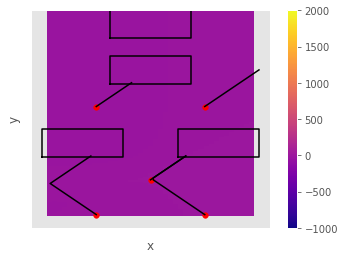

Ep[1000]: Running cost: 1072.22 	 Real cost: 2265.88


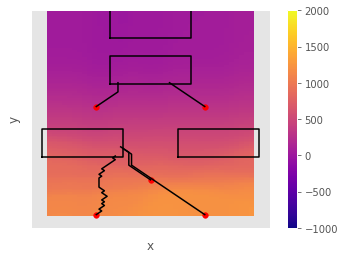

Ep[2000]: Running cost: 1750.69 	 Real cost: 2106.88


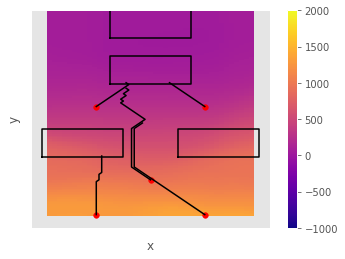

Ep[3000]: Running cost: 1581.57 	 Real cost: 2372.00


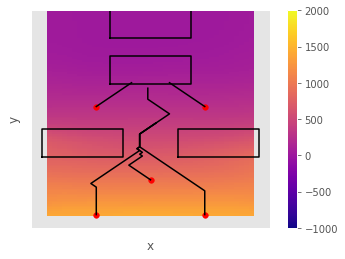

Ep[4000]: Running cost: 1280.18 	 Real cost: 2497.62


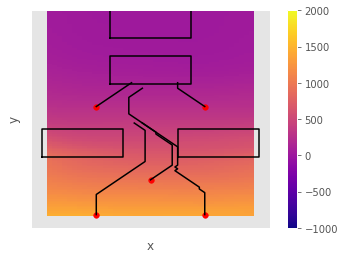

Ep[5000]: Running cost: 1015.77 	 Real cost: 3087.88


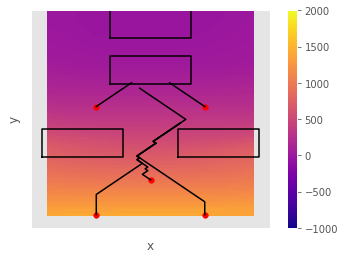

Ep[6000]: Running cost: 727.50 	 Real cost: -997.75


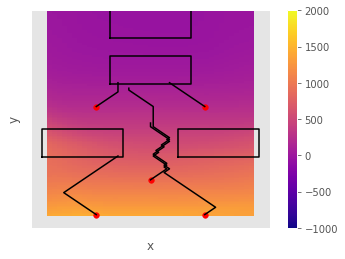

 At Ep[6017] Solved! Running cost is now -112.23!


In [5]:
#== TRAINING RECORD ==
TrainingRecord = namedtuple('TrainingRecord', ['ep', 'avg_cost', 'cost', 'loss_c'])
training_records = []
running_cost = 0.
running_cost_th = -50.
report_period = 1000

for ep in range(CONFIG.MAX_EPISODES):
    s = env.reset()
    ep_cost = 0.
    for step_num in range(CONFIG.MAX_EP_STEPS):
        if CONFIG.RENDER:
            env.render()
        # action selection
        a, a_idx = agent.select_action(s)

        # interact with env
        s_, r, done, _ = env.step(a_idx)
        
        ep_cost += r
        if done:
            s_ = None

        # Store the transition in memory
        agent.store_transition(s, a_idx, r, s_)
        s = s_

        # Perform one step of the optimization (on the target network)
        loss_c = agent.update()
        if done:
            break
    running_cost = running_cost * 0.9 + ep_cost * 0.1
    training_records.append(TrainingRecord(ep, running_cost, ep_cost, loss_c))
    print('{:d}: {:.1f}'.format(ep, ep_cost), end='\r')
    
    if ep % report_period == 0:
        print('\rEp[{:3.0f}]: Running cost: {:3.2f} \t Real cost: {:.2f}'.format(ep, running_cost, ep_cost))
        env.visualize_analytic_comparison(agent.Q_network, True)
        env.plot_trajectories(agent.Q_network, T=50, num_rnd_traj=5, states=env.visual_initial_states)
        plt.pause(0.001)
    if running_cost < running_cost_th:
        print("\r At Ep[{:3.0f}] Solved! Running cost is now {:3.2f}!".format(ep, running_cost))
        env.close()
        break
env.visualize_analytic_comparison(agent.Q_network, True)
env.plot_trajectories(agent.Q_network, T=30, num_rnd_traj=5, states=env.visual_initial_states)

[[1411.79394531 1387.45654297 1363.7701416  ...   -3.06926918
    -3.94880104   -4.79123497]
 [1419.65063477 1395.30102539 1371.54125977 ...   -4.65147972
    -5.45224571   -6.21878624]
 [1426.92773438 1402.56860352 1378.73986816 ...   -6.60972786
    -7.31785393   -7.99444008]
 ...
 [1350.85778809 1346.25793457 1340.23693848 ...  -10.34689236
   -10.71189785  -11.04020596]
 [1347.98864746 1343.1081543  1336.90869141 ...   -9.6212492
   -10.02595806  -10.39122677]
 [1344.59777832 1339.48876953 1333.3137207  ...   -9.10093212
    -9.53916836   -9.935256  ]]


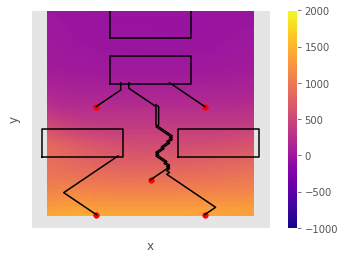

In [8]:
print(env.get_value(agent.Q_network))
env.visualize_analytic_comparison(agent.Q_network, True)
env.plot_trajectories(agent.Q_network, T=60, num_rnd_traj=5, states=env.visual_initial_states)

## Test --- Pendulum

In [ ]:
#== Pendulum ==
env_name='Pendulum-v0'
CONFIG = dqnConfig(DEVICE=device, BATCH_SIZE=64, ENV_NAME=env_name, GAMMA=0.9, MAX_EPISODES=1000)
env = gym.make(CONFIG.ENV_NAME)
env.seed(1)
s_dim = env.observation_space.shape[0]
a_dim = env.action_space.shape[0]
print(s_dim, a_dim)

action_num = 5
action_list = np.linspace(-2, 2, num=action_num, endpoint=True).reshape(-1,1)
r_enhance = lambda r: (r + 8)/8 # cost \in [~-16, 0] -> shift to about [-1, 1]

In [ ]:
#== AGENT ==
agent=DDQN(s_dim, action_num, CONFIG, action_list)
running_cost = 1000
running_cost_th = 180

#== TRAINING RECORD ==
TrainingRecord = namedtuple('TrainingRecord', ['ep', 'avg_cost', 'cost', 'loss_c'])
training_records = []

for ep in range(CONFIG.MAX_EPISODES):
    s = env.reset()
    ep_cost = 0.
    for step_num in range(CONFIG.MAX_EP_STEPS):
        print('\r {:d}'.format(step_num), end='')
        if CONFIG.RENDER:
            env.render()
        # action selection
        a, a_idx = agent.select_action(s)

        # interact with env
        s_, r, done, _ = env.step(a)
        r = -r
        ep_cost += r
        if done:
            s_ = None

        # Store the transition in memory
        agent.store_transition(s, a_idx, r_enhance(r), s_)
        s = s_

        # Perform one step of the optimization (on the target network)
        loss_c = agent.update()
        if done:
            break
    running_cost = running_cost * 0.9 + ep_cost * 0.1
    training_records.append(TrainingRecord(ep, running_cost, ep_cost, loss_c))

    if ep % 10 == 0:
        print('\rEp[{:3.0f}]: Running cost: {:3.2f} \t Real cost: {:.2f}'.format(ep, running_cost, ep_cost))
    if running_cost < running_cost_th:
        print("\rAt Ep[{:3.0f}] Solved! Running cost is now {:3.2f}!".format(ep, running_cost))
        env.close()
        break